In [44]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("oxford_iiit_pet:3.*.*", with_info=True)

import tensorflow as tf
from tensorflow.keras import backend

image_size = 512
mean = tf.constant([0.485, 0.456, 0.406])
std = tf.constant([0.229, 0.224, 0.225])


def normalize(input_image, input_mask):
    input_image = tf.image.convert_image_dtype(input_image, tf.float32)
    input_image = (input_image - mean) / tf.maximum(std, backend.epsilon())
    input_mask -= 1
    return input_image, input_mask


def load_image(datapoint):
    input_image = tf.image.resize(datapoint["image"], (image_size, image_size))
    input_mask = tf.image.resize(
        datapoint["segmentation_mask"],
        (image_size, image_size),
        method="bilinear",
    )

    input_image, input_mask = normalize(input_image, input_mask)
    input_image = tf.transpose(input_image, (2, 0, 1))
    return {"pixel_values": input_image, "labels": tf.squeeze(input_mask)}

auto = tf.data.AUTOTUNE
batch_size = 4

train_ds = (
    dataset["train"]
    .cache()
    .shuffle(batch_size * 10)
    .map(load_image, num_parallel_calls=auto)
    .batch(batch_size)
    .prefetch(auto)
)
test_ds = (
    dataset["test"]
    .map(load_image, num_parallel_calls=auto)
    .batch(batch_size)
    .prefetch(auto)
)

print(train_ds.element_spec)

{'pixel_values': TensorSpec(shape=(None, 3, 512, 512), dtype=tf.float32, name=None), 'labels': TensorSpec(shape=(None, 512, 512), dtype=tf.float32, name=None)}


2024-07-24 18:19:21.327210: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


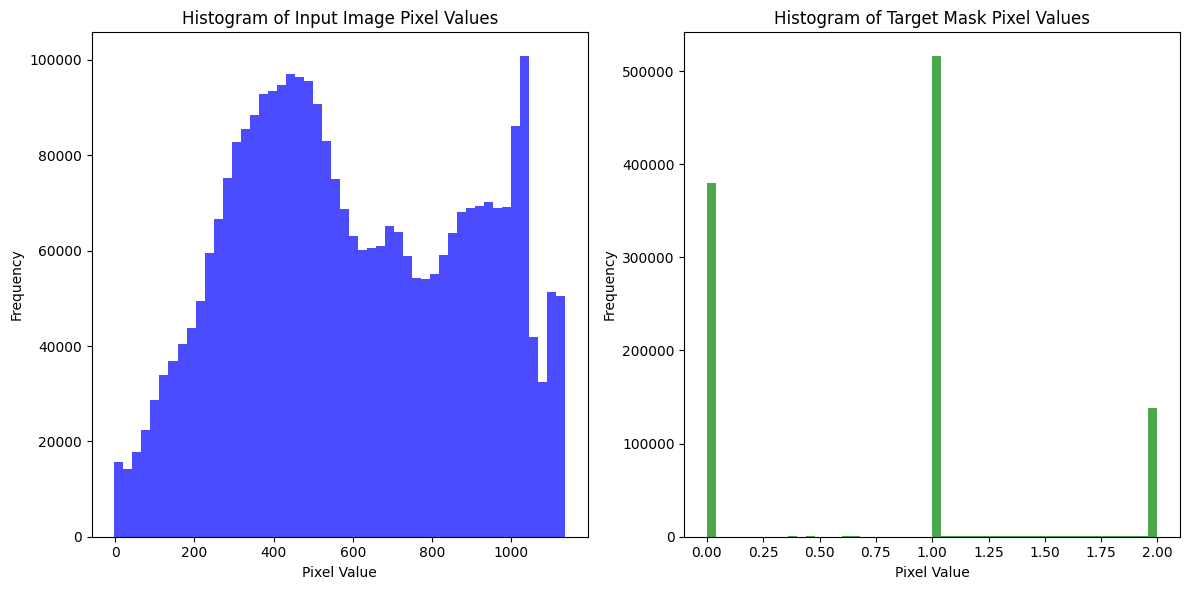

In [45]:
import matplotlib.pyplot as plt
import numpy as np

def plot_histograms(dataset):
    for batch in dataset.take(1):
        images = batch['pixel_values'].numpy()
        masks = batch['labels'].numpy()
        
        image_values = images.flatten()
        mask_values = masks.flatten()
        
        plt.figure(figsize=(12, 6))
        
        plt.subplot(1, 2, 1)
        plt.hist(image_values, bins=50, color='blue', alpha=0.7)
        plt.title('Histogram of Input Image Pixel Values')
        plt.xlabel('Pixel Value')
        plt.ylabel('Frequency')
        
        plt.subplot(1, 2, 2)
        plt.hist(mask_values, bins=50, color='green', alpha=0.7)
        plt.title('Histogram of Target Mask Pixel Values')
        plt.xlabel('Pixel Value')
        plt.ylabel('Frequency')
        
        plt.tight_layout()
        plt.show()
        break

plot_histograms(train_ds)


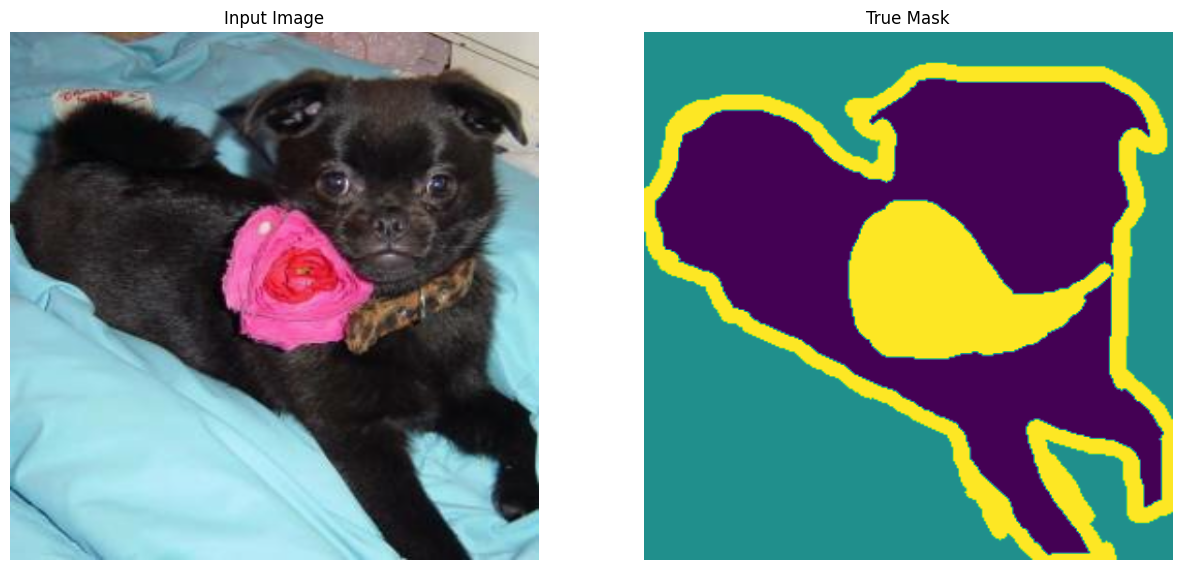

2024-07-24 18:19:26.427949: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


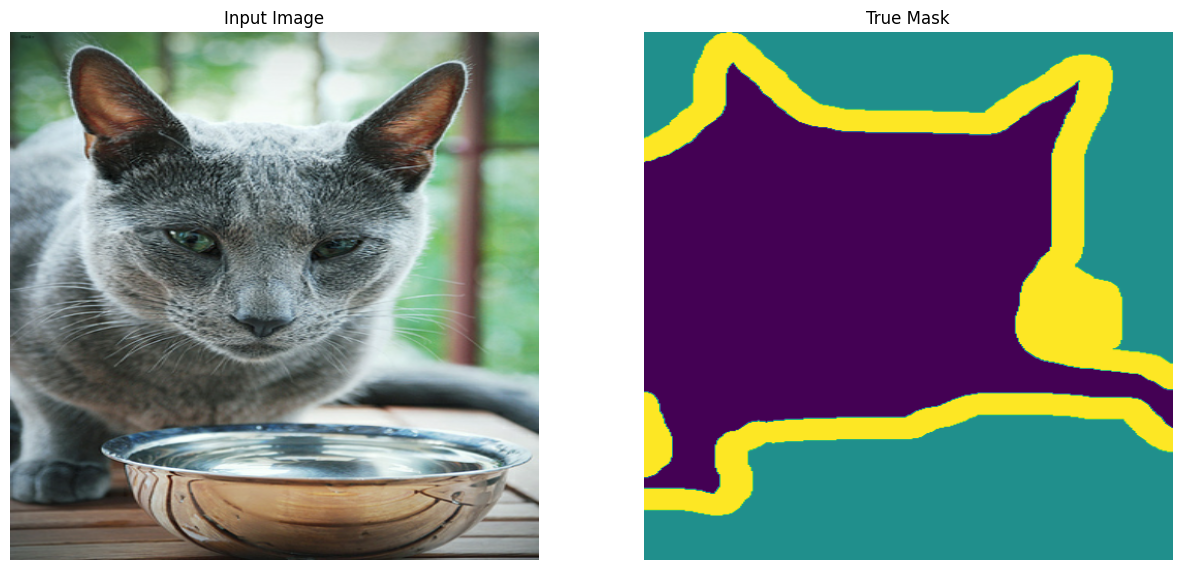

In [46]:
import matplotlib.pyplot as plt


def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ["Input Image", "True Mask", "Predicted Mask"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis("off")
    plt.show()


for samples in train_ds.take(2):
    sample_image, sample_mask = samples["pixel_values"][0], samples["labels"][0]
    sample_image = tf.transpose(sample_image, (1, 2, 0))
    sample_mask = tf.expand_dims(sample_mask, -1)
    display([sample_image, sample_mask])

In [47]:
sample_mask.shape

TensorShape([512, 512, 1])

In [48]:
 sample_image.shape

TensorShape([512, 512, 3])

In [49]:
from transformers import TFSegformerForSemanticSegmentation

model_checkpoint = "nvidia/mit-b0"
id2label = {0: "outer", 1: "inner", 2: "border"}
label2id = {label: id for id, label in id2label.items()}
num_labels = len(id2label)
model = TFSegformerForSemanticSegmentation.from_pretrained(
    model_checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

Some layers from the model checkpoint at nvidia/mit-b0 were not used when initializing TFSegformerForSemanticSegmentation: ['classifier']
- This IS expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFSegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [50]:
lr = 0.00006
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=optimizer)

In [51]:
from IPython.display import clear_output


def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=1)
    pred_mask = tf.expand_dims(pred_mask, -1)
    return pred_mask[0]


def show_predictions(dataset=None, num=1):
    if dataset:
        for sample in dataset.take(num):
            images, masks = sample["pixel_values"], sample["labels"]
            masks = tf.expand_dims(masks, -1)
            pred_masks = model.predict(images).logits
            images = tf.transpose(images, (0, 2, 3, 1))
            display([images[0], masks[0], create_mask(pred_masks)])
    else:
        display(
            [
                sample_image,
                sample_mask,
                create_mask(model.predict(tf.expand_dims(sample_image, 0))),
            ]
        )


class DisplayCallback(tf.keras.callbacks.Callback):
    def __init__(self, dataset, **kwargs):
        super().__init__(**kwargs)
        self.dataset = dataset

    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions(self.dataset)
        print("\nSample Prediction after epoch {}\n".format(epoch + 1))

In [52]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    callbacks=[DisplayCallback(test_ds)],
    epochs=1,
)

2024-07-24 18:19:40.236056: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


  2/920 [..............................] - ETA: 1:47:52 - loss: 1.1714

KeyboardInterrupt: 

In [53]:
import tensorflow as tf
from tensorflow.keras import backend
import nibabel as nib
import tensorflow as tf
import os
import keras
from keras import layers

from glob import glob
import cv2
from scipy.io import loadmat
import matplotlib.pyplot as plt

from tensorflow import image as tf_image
from tensorflow import data as tf_data
from tensorflow import io as tf_io

In [54]:
image_size = 512

input_dir = "/Users/diarmuidegan/Documents/digi_pathology/LA"
target_dir = "/Users/diarmuidegan/Documents/digi_pathology/LA_gt"

mean = tf.constant([229.84518198986675])
std = tf.constant([147.88746550506525])


def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32)
    input_image = (input_image - mean) / tf.maximum(std, tf.keras.backend.epsilon())
    #input_mask -= 1
    return input_image, input_mask

def load_nii_image(image_path, mask_path):
    input_image = nib.load(image_path.numpy().decode()).get_fdata()
    input_mask = nib.load(mask_path.numpy().decode()).get_fdata()
    
    if input_image.ndim == 2:
        input_image = input_image[..., np.newaxis]
    if input_mask.ndim == 2:
        input_mask = input_mask[..., np.newaxis]
    
    return input_image, input_mask

def preprocess(input_image, input_mask):
    # Set the shape explicitly
    input_image.set_shape([512, 512, 1])
    input_mask.set_shape([512, 512, 1])
    
    input_image = tf.image.resize(input_image, (image_size, image_size))
    input_mask = tf.image.resize(input_mask, (image_size, image_size), method="nearest")
    
    input_image, input_mask = normalize(input_image, input_mask)
    
    input_image = tf.transpose(input_image, (2, 0, 1))  # (1, 512, 512)
    input_image = tf.tile(input_image, [3, 1, 1])  # (3, 512, 512)
    
    return {"pixel_values": input_image, "labels": tf.squeeze(input_mask)}



def create_dataset(input_dir, target_dir, batch_size=4):
    input_paths = sorted([os.path.join(input_dir, fname) for fname in os.listdir(input_dir) if fname.endswith('.nii')])
    target_paths = sorted([os.path.join(target_dir, fname) for fname in os.listdir(target_dir) if fname.endswith('.nii')])

    train_input_paths = input_paths[:160]
    val_input_paths = input_paths[160:200]
    test_input_paths = input_paths[200:]

    train_target_paths = target_paths[:160]
    val_target_paths = target_paths[160:200]
    test_target_paths = target_paths[200:]

    def create_split_dataset(input_paths, target_paths):
        dataset = tf.data.Dataset.from_tensor_slices((input_paths, target_paths))
        dataset = dataset.map(lambda x, y: tf.py_function(func=load_nii_image, inp=[x, y], Tout=[tf.float32, tf.float32]))
        dataset = dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
        return dataset

    train_ds = create_split_dataset(train_input_paths, train_target_paths)
    val_ds = create_split_dataset(val_input_paths, val_target_paths)
    test_ds = create_split_dataset(test_input_paths, test_target_paths)

    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = create_dataset(input_dir, target_dir, batch_size=4)

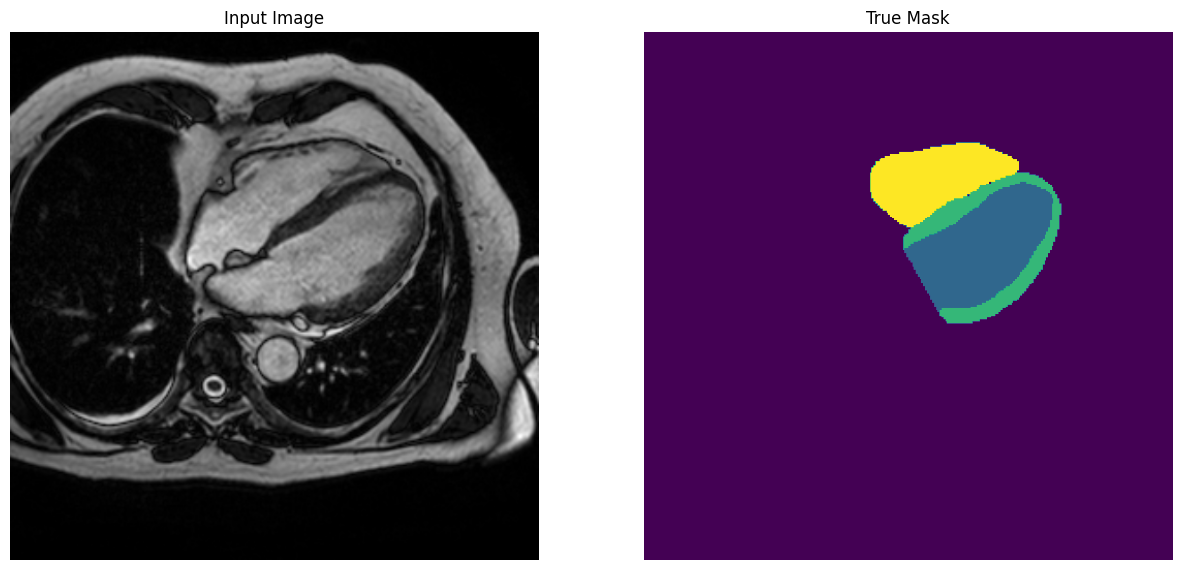

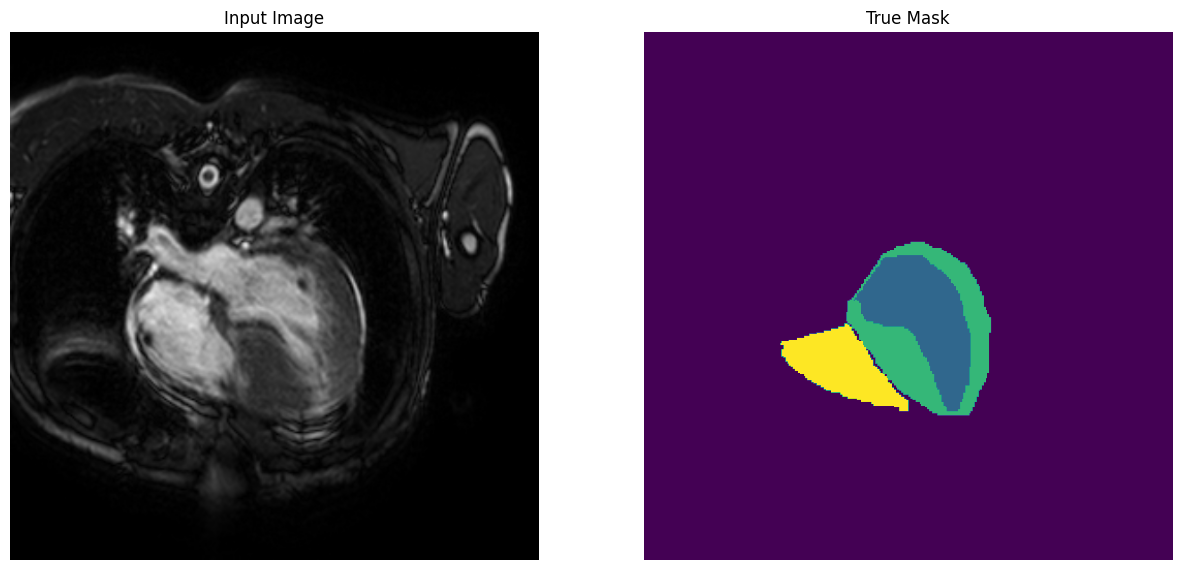

In [56]:
for samples in val_ds.take(2):
    sample_image, sample_mask = samples["pixel_values"][0], samples["labels"][0]
    sample_image = tf.transpose(sample_image, (1, 2, 0))
    sample_mask = tf.expand_dims(sample_mask, -1)
    display([sample_image, sample_mask])

In [57]:
print(train_ds.element_spec)

{'pixel_values': TensorSpec(shape=(None, 3, 512, 512), dtype=tf.float32, name=None), 'labels': TensorSpec(shape=(None, 512, 512), dtype=tf.float32, name=None)}


In [58]:
model_checkpoint = "nvidia/mit-b1"
id2label = {0: "Background", 1: "RV", 2: "MYO ", 3:"LV"}
label2id = {label: id for id, label in id2label.items()}
num_labels = len(id2label)
model = TFSegformerForSemanticSegmentation.from_pretrained(
    model_checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

Some layers from the model checkpoint at nvidia/mit-b1 were not used when initializing TFSegformerForSemanticSegmentation: ['classifier']
- This IS expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFSegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [59]:
lr = 0.00006
optimizer = tf.keras.optimizers.AdamW(learning_rate=lr)
model.compile(optimizer=optimizer, metrics=["accuracy", keras.metrics.IoU(num_classes=4, target_class_ids=[0])])

In [60]:
epochs = 1

history = model.fit(
    train_ds,
    validation_data=train_ds,
    callbacks=[DisplayCallback(train_ds)],
    epochs=epochs)

ValueError: in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/modeling_tf_utils.py", line 1711, in train_step
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/compile_utils.py", line 620, in update_state
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/utils/metrics_utils.py", line 77, in decorated
        result = update_state_fn(*args, **kwargs)
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/metrics/base_metric.py", line 140, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/metrics/base_metric.py", line 723, in update_state  **
        matches = ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/metrics/accuracy_metrics.py", line 459, in sparse_categorical_accuracy
        matches = metrics_utils.sparse_categorical_matches(y_true, y_pred)
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/utils/metrics_utils.py", line 969, in sparse_categorical_matches
        matches = tf.cast(tf.equal(y_true, y_pred), backend.floatx())

    ValueError: Dimensions must be equal, but are 512 and 4 for '{{node Equal}} = Equal[T=DT_FLOAT, incompatible_shape_error=true](IteratorGetNext, Cast_1)' with input shapes: [?,512,512], [?,4,128].
